In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt

import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import cmocean.cm as cmo
import datetime

sns.set_theme(context='notebook', style='whitegrid')
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 150
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from Streamfunctions import *
from SWMT_decomposition import *

import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

from ant_plots import *

In [3]:

collect_budget_files()

['/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1850-1854.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1855-1859.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1860-1864.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1865-1869.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1870-1874.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1875-1879.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1880-1884.zarr',
 '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigm

In [2]:

import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def plot_antarctic_plot(ds, ax, cmap = None, norm = None, 
                        exp = "forced", variable = "mass_tendency", 
                        mass_flux_units_conversion = 1, 
                       draw_gridlines = True, mask_small_values = True):

    wmt_mean_budget =  mass_flux_units_conversion * ds.sel(exp = exp)[variable]
    # wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    
    if mask_small_values: 
        wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
        
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax.coastlines();
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
   
    if draw_gridlines: 
        # Draw meridian lines with labels around circular boundary
        gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                        xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                        color='gray', alpha=0.25, linestyle='-', zorder=10, 
                        xlabel_style = {"fontsize":9.5})
    
        
    ax.set_boundary(circle, transform=ax.transAxes)

    return cm

### Load in data

In [3]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"

In [4]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x

In [5]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget_bug_fixed.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]

ds["surface_boundary_fluxes_salt"] = 1 * ds["boundary_fluxes_salt"]
ds["surface_boundary_fluxes_heat"] = ds["boundary_fluxes_heat"] - ds["bottom_flux_heat"]

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"


In [6]:
def cftime_to_decimal_year(times):
    """Convert xarray cftime to decimal years"""
    result = []
    for t in times:
        year = t.year
        start = type(t)(year, 1, 1, calendar=getattr(t, 'calendar', None))
        end = type(t)(year + 1, 1, 1, calendar=getattr(t, 'calendar', None))
        days_in_year = (end - start).days
        day_of_year = (t - start).days + (t - start).seconds / 86400.0
        result.append(year + day_of_year / days_in_year)
    return result

In [7]:
sigma = 36.974
use_averaging = True 
if use_averaging: 
    ds_yearly = ds.groupby("time.year").mean("time")
    # ds_yearly = rolling_average(ds)
    # ds_yearly = extract_winter_temps(ds)
else: 
    ds_yearly = ds.copy()
    ds_yearly.coords["time"] = cftime_to_decimal_year(ds.time.values)
    ds_yearly = ds_yearly.rename({"time":"year"})
psi40_abyssal = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).convergent_mass_transport
abyssal_dmdt = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).mass_tendency
abyssal_sbf = ds_yearly.sel(sigma2_l_target = slice(20, 37.1))["surface_boundary_fluxes"]
# ds_sigma = ds_yearly.sel(sigma2_l_target = sigma, method = "nearest")

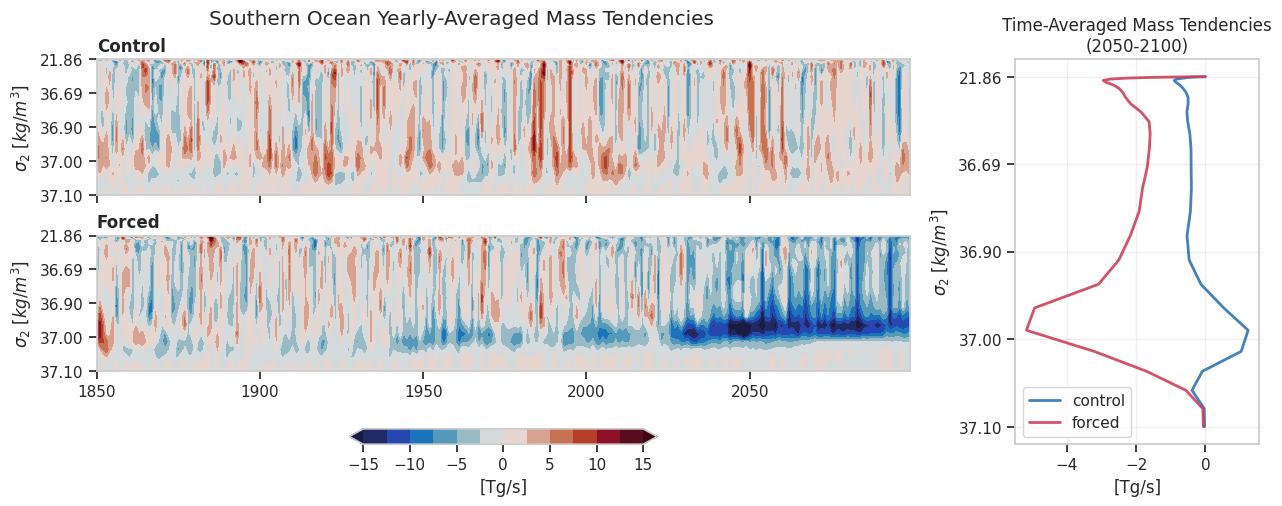

In [8]:
toTg = 1e-9 

# Create a 2×2 GridSpec where the right column spans both rows
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-15, 15 + 0.1, 2.5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Mass Tendencies ", x = 0.37)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")
ax[0].tick_params(labelbottom=False)

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()


abyssal_dmdt_mean = abyssal_dmdt.sel(year = slice(-50, None)).mean("year")
abyssal_dmdt_mean = toTg *abyssal_dmdt_mean
control_mean = abyssal_dmdt_mean.sel(exp = "control")
forced_mean = abyssal_dmdt_mean.sel(exp = "forced")

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Mass Tendencies\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

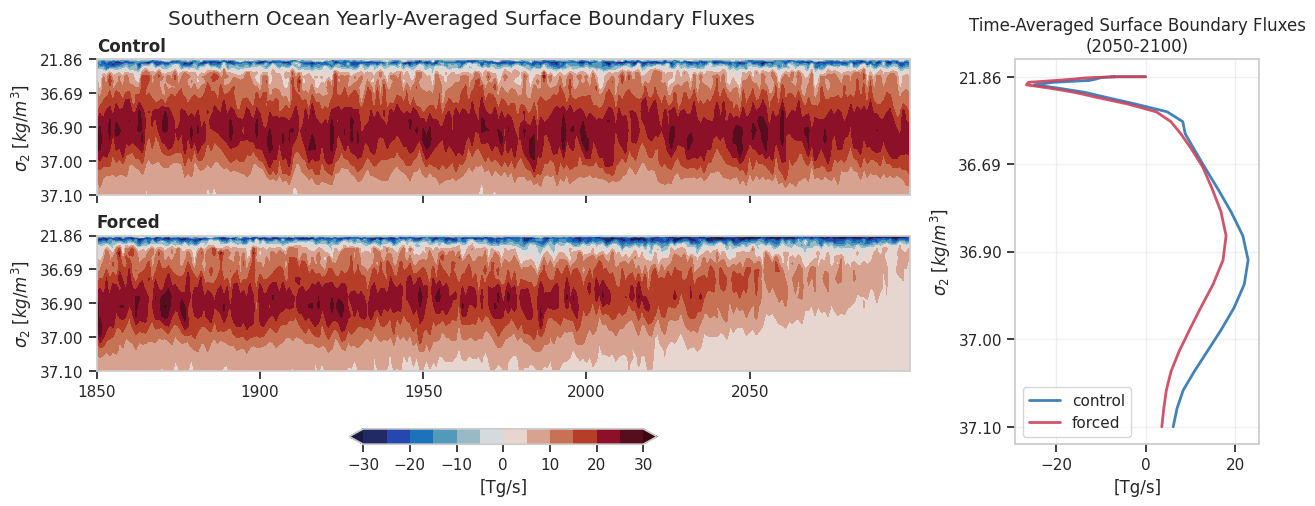

In [9]:
toTg = 1e-9 

# Create a 2×2 GridSpec where the right column spans both rows
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
ax[0].tick_params(labelbottom=False)

year = abyssal_sbf.year
density =  abyssal_sbf.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-30, 30 + 0.1, 5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Surface Boundary Fluxes ", x = 0.37)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()

abyssal_sbf_mean = abyssal_sbf.sel(year = slice(-50, None)).mean("year")
abyssal_sbf_mean = toTg *abyssal_sbf_mean
control_mean = abyssal_sbf_mean.sel(exp = "control")
forced_mean = abyssal_sbf_mean.sel(exp = "forced")

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Surface Boundary Fluxes\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

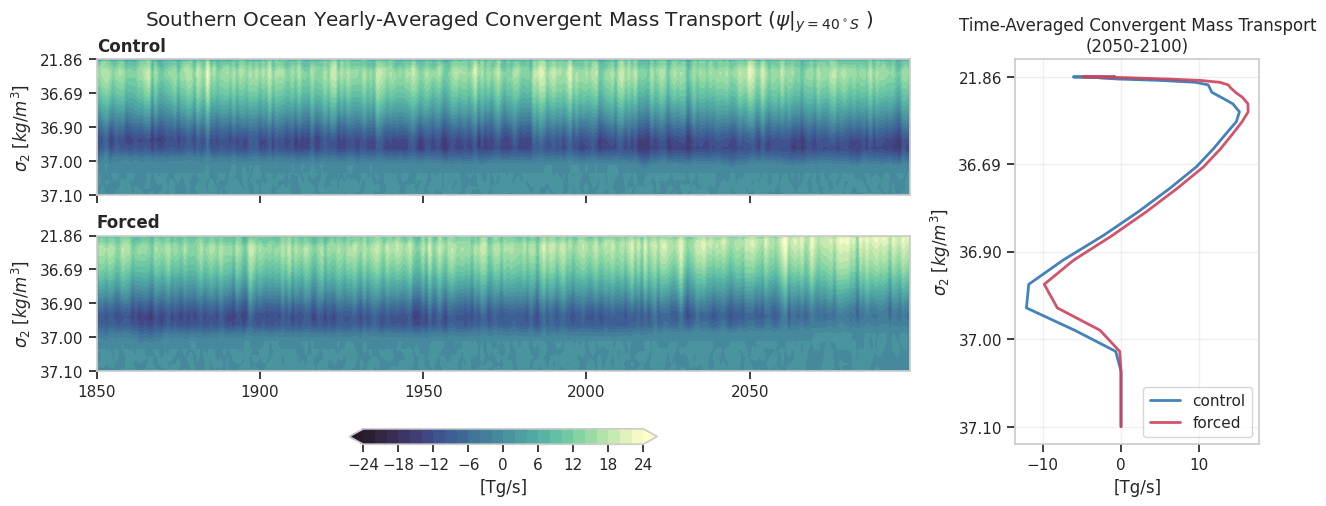

In [10]:
toTg = 1e-9 

# Create a 2×2 GridSpec where the right column spans both rows
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
ax[0].tick_params(labelbottom=False)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-24, 24 + 0.1, 2.0)
ax[0].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

cm = ax[1].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Convergent Mass Transport " + r"($\psi|_{y = 40^\circ S}$ )", x = 0.4)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()

psi40_abyssal_mean = psi40_abyssal.sel(year = slice(-50, None)).mean("year")
psi40_abyssal_mean = toTg *psi40_abyssal_mean
control_mean = psi40_abyssal_mean.sel(exp = "control")
forced_mean = psi40_abyssal_mean.sel(exp = "forced")

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Convergent Mass Transport\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

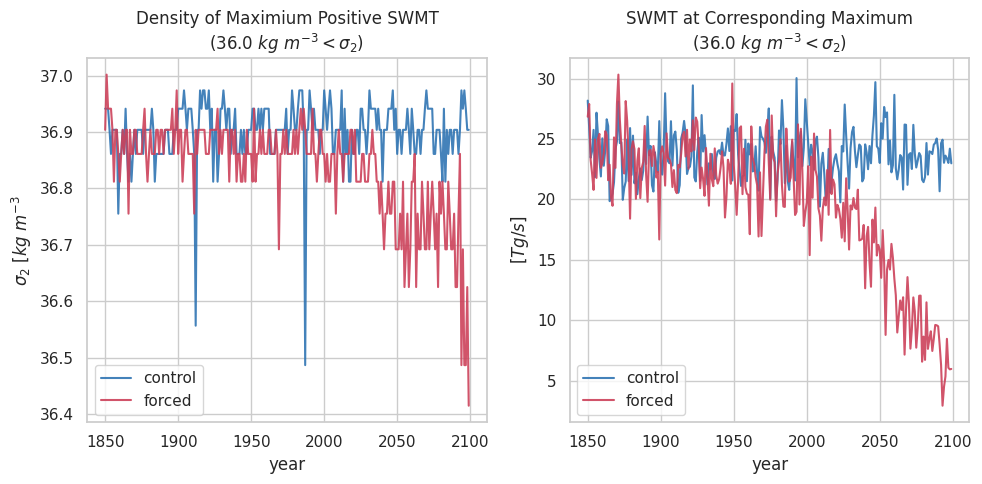

In [11]:
abyssal_sbf_crop = abyssal_sbf.sel(sigma2_l_target = slice(36.2, None))
abyssal_sbf_crop = abyssal_sbf_crop.where(abyssal_sbf_crop > 0)
max_locations = abyssal_sbf_crop.argmax("sigma2_l_target")

control_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "control")].rename("max_surface_boundary_flux_density")
forced_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "forced")].rename("max_surface_boundary_flux_density")

max_sbf_loc = xr.concat([control_max, forced_max], dim = "exp")

def select_from_max_location(ds, max_sbf_loc):
    """Select data from maximum locations in control and forced experiments."""
    results = {}
    
    for exp in ["control", "forced"]:
        exp_data = []
        for y in ds.year:
            # print(max_sbf_loc.sel(exp=exp, year=y))
            exp_data += [ds.sel(exp=exp, year=y).sel(sigma2_l_target=max_sbf_loc.sel(exp=exp, year=y).values)]
        results[exp] = xr.concat(exp_data, dim="year")
    
    return xr.concat(list(results.values()), dim="exp")

def select_from_yearly_max_location_monthly(ds, max_sbf_loc):
    """Select monthly data from maximum locations in control and forced experiments."""
    results = {}
    
    # First, add year as a coordinate if it doesn't exist
    if 'year' not in ds.coords:
        ds = ds.assign_coords(year=ds.time.dt.year)
    
    for exp in ["control", "forced"]:
        exp_monthly_data = []
        
        # Group by year
        for year, year_data in ds.sel(exp=exp).groupby('year'):
            # Get the max location for this year
            max_loc = max_sbf_loc.sel(exp=exp, year=year).values
            
            # Select data at this location for all months in this year
            selected_data = year_data.sel(sigma2_l_target=max_loc)
            
            # Add to our results
            exp_monthly_data.append(selected_data)
        
        # Combine all years for this experiment
        results[exp] = xr.concat(exp_monthly_data, dim="time")
    
    # Combine both experiments
    return xr.concat(list(results.values()), dim="exp")

# Apply the function to your monthly data
# max_sbf_monthly = select_from_max_location_monthly(abyssal_sbf_crop_monthly, max_sbf_loc)
max_sbf = select_from_max_location(abyssal_sbf_crop, max_sbf_loc)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
max_sbf_loc_rolling = max_sbf_loc.rolling(year=1, center=True).mean().dropna("year")
expts = ["control", "forced"]
for expt in expts:
    max_sbf_loc_rolling.sel(exp =expt).plot(ax = ax[0], c = expt_colors[expt], label = expt, alpha = .9)
ax[0].legend()
ax[0].set_ylabel(r"$\sigma_2 \ [kg\ m^{-3}$")
ax[0].set_title("Density of Maximium Positive SWMT\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

max_sbf_rolling = toTg * max_sbf.rolling(year=1, center=True).mean().dropna("year")
for expt in expts:
    max_sbf_rolling.sel(exp =expt).plot(ax = ax[1], c = expt_colors[expt], label = expt, alpha = .9)
ax[1].legend()
ax[1].set_ylabel(r"$[Tg/s]$")

ax[1].set_title("SWMT at Corresponding Maximum\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

fig.tight_layout()

In [12]:
ds_sfc = xr.open_mfdataset(datadir(f"/model/Southern_Ocean_Surface_Advection_and_Tendency_sigma_slice.nc"))
ds_sfc_SWMT = get_SWMT(ds_sfc)
max_PI_loc = max_sbf_loc.sel(exp = "forced").sel(year = slice(1850, 1900)).mean("year")
# ds_sfc_SWMT = select_from_max_location(ds_sfc_SWMT, max_sbf_loc).compute()

In [13]:
ds_sfc_at_max = ds_sfc_SWMT.sel(sigma2_l_target = max_PI_loc.values, method = "nearest")

In [14]:
mass_flux_units_conversion = toTg / (ds_sfc_at_max.areacello / (100e3 **2 ))
mass_flux_units = r"$Tg/100^2 km^2 / s$"

In [26]:
sns.set_theme(context='notebook', style='whitegrid')
mpl.rcParams['figure.dpi'] = 150


In [27]:
targ_dens = float(np.float32(ds_sfc_at_max.sigma2_l_target.values))
targ_dens = np.round(targ_dens, decimals = 3)
targ_dens

np.float64(36.904)

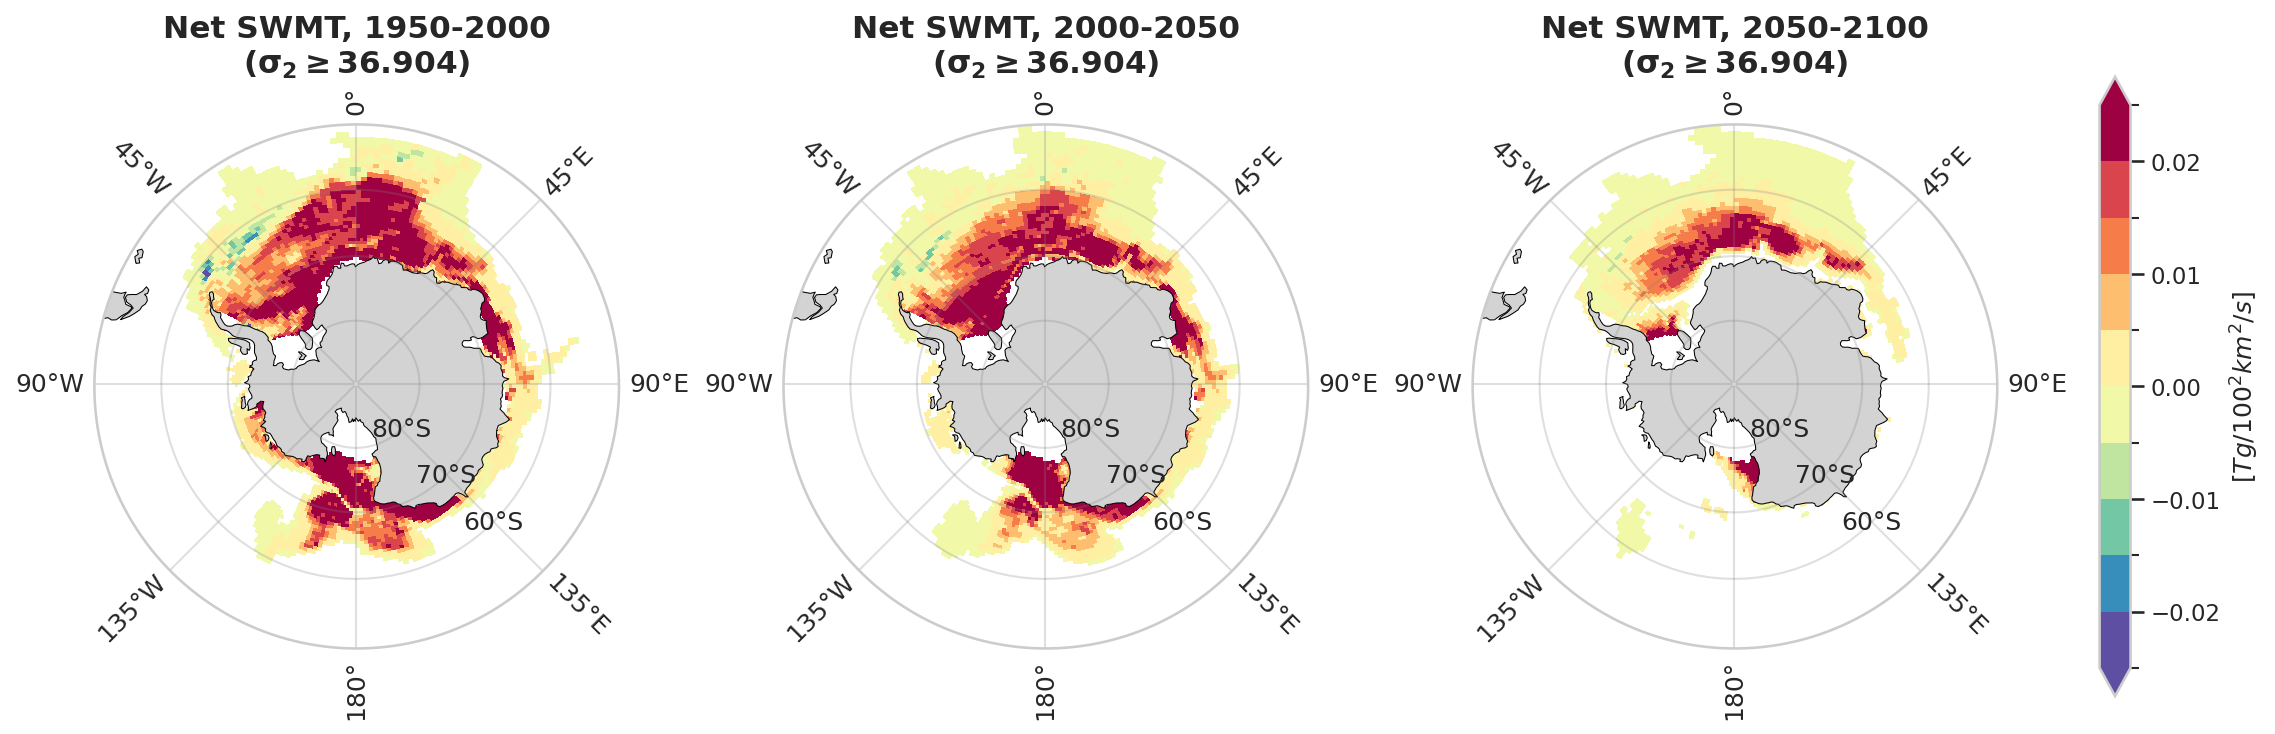

In [29]:
density_title = r"$\mathbf{(\sigma_2 \geq 36.904)}$"
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.05, 0.0501, 0.01) / 2
boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 3, figsize = (15, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times_list = [(1950, 2000), (2000, 2050), (2050, 2100)]

for (i, times) in enumerate(times_list):

    var = ds_sfc_at_max.sel(year = slice(times[0], times[1])).sel(exp = "forced").mean("year")
    curr_width = 0.0
    cm = plot_antarctic(var["SWMT"] * mass_flux_units_conversion, ax[i], cmap = cmap, norm = norm)
        
    ax[i].set_title("Net SWMT, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
                 fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")